# ISSR Prediction Models

## Imports

In [3]:
#imports
import pandas as pd
import matplotlib.pyplot as plt
import math
import seaborn as sns
import warnings
import numpy as np
from datetime import datetime, timedelta
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, confusion_matrix
from statsmodels.tsa.arima.model import ARIMA
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
from sklearn.preprocessing import MinMaxScaler
from pandas.plotting import autocorrelation_plot
from imblearn.under_sampling import RandomUnderSampler
import keras_tuner as kt
from joblib import Parallel, delayed
from tensorflow.keras.optimizers import Adam

## Load Dataset

In [4]:
#Load in the ISSR Dataset that covers 2021-2023
data = pd.read_csv("C:/Users/Nicholas Weber/Downloads/Buffalo_issr2021.csv")

In [5]:
#Print the head of the Dataset
data.head()

,id_,year,month,day,hour,reltime,numlev,p_src,np_src,lat,...,timestamp,temp_f,temp_k,press_alt,rh_ice,issc,day_of_year,volume,floor,ceiling
0,#USM00072528,2021,1,1,0,2310,176,ncdc-nws,ncdc-nws,429411,...,2021-01-01 00:00:00,33.62,274.05,353.44,0.727,no,1-1,0.25,0.0,0.0
1,#USM00072528,2021,1,1,0,2310,176,ncdc-nws,ncdc-nws,429411,...,2021-01-01 00:00:01,33.62,274.05,363.64,0.727,no,1-1,0.25,0.0,0.0
2,#USM00072528,2021,1,1,0,2310,176,ncdc-nws,ncdc-nws,429411,...,2021-01-01 00:00:25,32.00,273.15,763.30,0.740,no,1-1,0.25,0.0,0.0
3,#USM00072528,2021,1,1,0,2310,176,ncdc-nws,ncdc-nws,429411,...,2021-01-01 00:01:04,28.76,271.35,1507.31,0.737,no,1-1,0.25,0.0,0.0
4,#USM00072528,2021,1,1,0,2310,176,ncdc-nws,ncdc-nws,429411,...,2021-01-01 00:01:58,24.08,268.75,2498.86,0.859,no,1-1,0.25,0.0,0.0


## Filter to 2022 and 2023

In [6]:
#Filter to 2022 and 2023. This will be used for training and testing
df = data[(data['year'] >= 2022) & (data['year'] <= 2023) & (data['press'] != -9999)]

## Preprocessing

### Convert issc from characters to integers

In [7]:
#Convert categoricals into numerics to feed into our machine learning models
warnings.filterwarnings("ignore")
df['issc'] = df['issc'].replace({'yes': 1, 'no': 0})

In [10]:
#Print DataFrame
df

,id_,year,month,day,hour,reltime,numlev,p_src,np_src,lat,...,timestamp,temp_f,temp_k,press_alt,rh_ice,issc,day_of_year,volume,floor,ceiling
133,#USM00072528,2022,1,1,0,2301,227,ncdc-nws,ncdc-gts,429411,...,2022-01-01 00:00:00,40.28,277.75,786.48,0.908,0,1-1,0.25,0.0,0.0
134,#USM00072528,2022,1,1,0,2301,227,ncdc-nws,ncdc-gts,429411,...,2022-01-01 00:00:18,40.46,277.85,1168.85,0.882,0,1-1,0.25,0.0,0.0
135,#USM00072528,2022,1,1,0,2301,227,ncdc-nws,ncdc-gts,429411,...,2022-01-01 00:00:27,41.36,278.35,1332.83,0.781,0,1-1,0.25,0.0,0.0
136,#USM00072528,2022,1,1,0,2301,227,ncdc-nws,ncdc-gts,429411,...,2022-01-01 00:00:29,41.54,278.45,1372.03,0.784,0,1-1,0.25,0.0,0.0
137,#USM00072528,2022,1,1,0,2301,227,ncdc-nws,ncdc-gts,429411,...,2022-01-01 00:01:10,37.94,276.45,2135.52,0.952,0,1-1,0.25,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
332167,#USM00072528,2023,12,31,12,1109,223,ncdc-nws,ncdc-gts,429411,...,2023-12-31 12:43:58,-59.44,222.35,40837.02,0.023,0,12-31,0.25,0.0,0.0
332168,#USM00072528,2023,12,31,12,1109,223,ncdc-nws,ncdc-gts,429411,...,2023-12-31 12:45:12,-61.78,221.05,41838.00,0.025,0,12-31,0.25,0.0,0.0
332169,#USM00072528,2023,12,31,12,1109,223,ncdc-nws,ncdc-gts,429411,...,2023-12-31 12:45:53,-63.22,220.25,42393.97,0.026,0,12-31,0.25,0.0,0.0
332170,#USM00072528,2023,12,31,12,1109,223,ncdc-nws,ncdc-gts,429411,...,2023-12-31 12:45:55,-63.22,220.25,42417.66,0.026,0,12-31,0.25,0.0,0.0


## Time Series Modeling

In [18]:
#Create DataFrame with volume column. Volume is based off of the number of times per day that an issc was yes
df['date'] = pd.to_datetime(df['date'])
issc_counts_per_day = df[df['issc'] == 1].groupby(df['date'].dt.date).size()
temp_count = df[df['temp_f'] < -42].groupby(df['date'].dt.date).size()
rh_ice_count = df[df['rh_ice'] > 1].groupby(df['date'].dt.date).size()

all_dates = pd.DataFrame(index=pd.date_range(start=df['date'].min(), end=df['date'].max(), freq='D'))
issc_counts_per_day.name = 'volume'
temp_count.name = 'temp_volume'
rh_ice_count.name = 'rhi_volume'

df2 = all_dates.join(issc_counts_per_day, how='left').fillna(0)

df3 = pd.merge(df2, temp_count, left_index = True, right_index = True, how = 'left').fillna(0)

new_df = pd.merge(df3, rh_ice_count, left_index = True, right_index = True, how = 'left').fillna(0)


In [19]:
#Print DataFrame
new_df

,volume,temp_volume,rhi_volume
2022-01-01,0.0,54.0,0.0
2022-01-02,1.0,52.0,20.0
2022-01-03,0.0,46.0,3.0
2022-01-04,0.0,68.0,3.0
2022-01-05,0.0,57.0,0.0
...,...,...,...
2023-12-27,1.0,71.0,1.0
2023-12-28,0.0,51.0,2.0
2023-12-29,0.0,61.0,6.0
2023-12-30,3.0,81.0,25.0


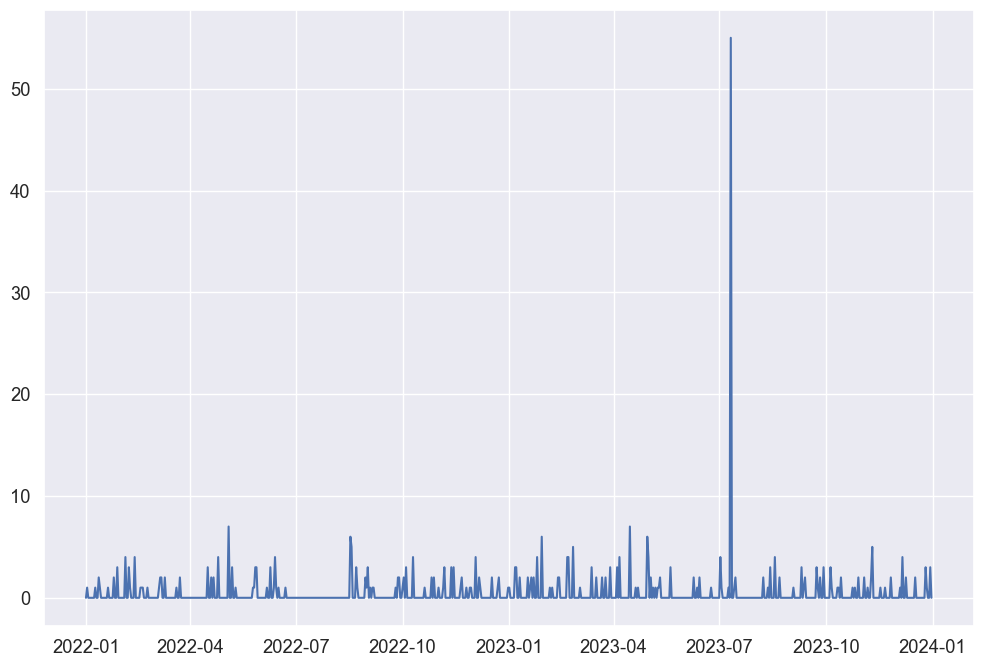

In [20]:
plt.figure(figsize = (12, 8))
plt.plot(new_df['volume'])

Analysis: There is a large outlier on July 11, 2023. This needs to be removed to output a more accurate time series model. 

## Autoregressive Integrated Moving Average (ARIMA) Model

In [21]:
new_df.drop('2023-07-11', inplace = True)

In [22]:
#Source: https://machinelearningmastery.com/arima-for-time-series-forecasting-with-python/
#Source: https://www.investopedia.com/terms/a/autoregressive-integrated-moving-average-arima.asp
#ARIMA is statistical analysis model that uses time series data to predict future trends. This model can predict
#future values based on past values. ARIMA parameters include:
#p: the number of lag observations in the model
#d: the number of times the raw observations are differenced
#q: the size of the moving average window
#The ARIMA model identifies the appropriate number of lags.

#Splitting Training and Testing set
train_size = int(0.8 * len(new_df))
train, test = new_df.iloc[:train_size], new_df.iloc[train_size:]

# Fit ARIMA model
#Order represents, p, d, q. 
model = ARIMA(train['volume'], order=(3,1,3))
model_fit = model.fit()

# Make predictions
predictions = model_fit.forecast(steps=len(test))

In [23]:
#Root Mean Squared Error is used to evaluate the model. RMSE takes the square root fo the average of the squared
#differences between the predicted values and the actual values.The lower the RMSE, the more accurate the model.
mse = mean_squared_error(test['volume'], predictions)

print("Mean Squared Error (MSE):", mse)

Mean Squared Error (MSE): 0.9892988981850243


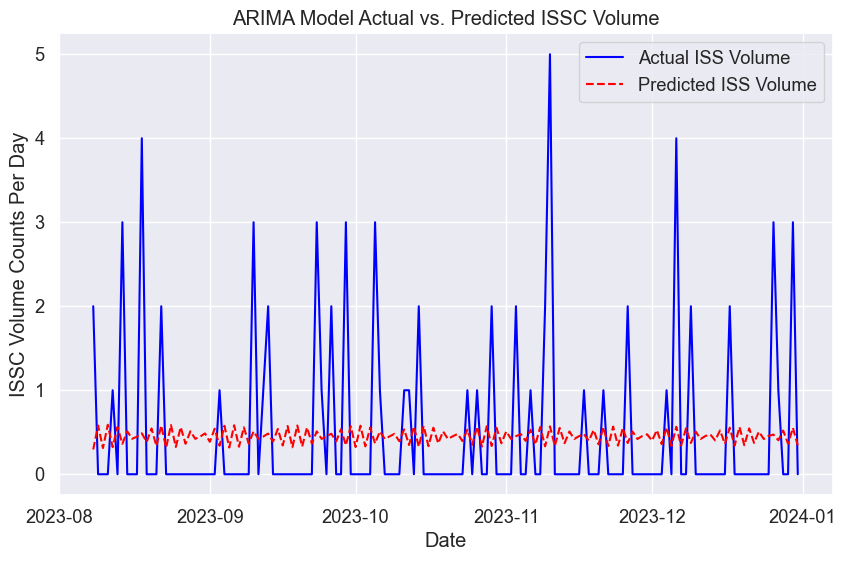

In [24]:
#Plotting Predicted versus Actual ISSC Volume Per Day
plt.figure(figsize=(10, 6))
plt.plot(test.index, test['volume'], label='Actual ISS Volume', color='blue')
plt.plot(test.index, predictions, label='Predicted ISS Volume', color='red', linestyle='--')
plt.title('ARIMA Model Actual vs. Predicted ISSC Volume')
plt.xlabel('Date')
plt.ylabel('ISSC Volume Counts Per Day')
plt.legend()
plt.grid(True)
plt.show()

Analysis: First attempt at ARIMA did not yield great results. Need to try different parameters.

### ARIMA Parameter Tuning

In [25]:
#Assign ARIMA Paramters
#Source: https://machinelearningmastery.com/grid-search-arima-hyperparameters-with-python/
#Source: https://levelup.gitconnected.com/simple-forecasting-with-auto-arima-python-a3f651271965
p_values = [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10]
d_values = range(0,3)
q_values = range(0,3)

In [26]:
#Function that evaluates the ARIMA Model

def eval_arima_model(train, test, p_values, d_values, q_values):
    #Save best mse score, best parameters, and predictions made
    best_score, best_param, predict = float("inf"), None, float("inf")
    
    for p in p_values:
        for d in d_values:
            for q in q_values:
                order = (p, d, q)
                try:
                    model = ARIMA(train['volume'], order=(p, d, q))
                    model_fit = model.fit()
                    # Make predictions
                    predictions = model_fit.forecast(steps=len(test))
                    mse = (mean_squared_error(test['volume'], predictions))
                    print("The parameters p:", p, ", d:", d, ", q:", q, ". MSE =", mse)
                    #If mse is lower than the current best mse score, add that as the new mse
                    if mse < best_score:
                        best_score, best_param, predict = mse, order, predictions
                except:
                    continue
    print("Best ARIMA MSE Score =", best_score, best_param)
    
    #Plotting Predicted versus Actual ISSC Volume Per Day
    plt.figure(figsize=(10, 6))
    plt.plot(test.index, test['volume'], label='Actual ISS Volume', color='blue')
    plt.plot(test.index, predict, label='Predicted ISS Volume', color='red', linestyle='--')
    plt.title('ARIMA Model Actual vs. Predicted ISSC Volume')
    plt.xlabel('Date')
    plt.ylabel('ISSC Volume Counts Per Day')
    plt.legend()
    plt.grid(True)
    plt.show()

The parameters p: 0 , d: 0 , q: 0 . MSE = 0.9901070856942309
The parameters p: 0 , d: 0 , q: 1 . MSE = 0.9906419135530118
The parameters p: 0 , d: 0 , q: 2 . MSE = 0.9902975906236035
The parameters p: 0 , d: 1 , q: 0 . MSE = 1.2191780821917808
The parameters p: 0 , d: 1 , q: 1 . MSE = 0.9901068046001588
The parameters p: 0 , d: 1 , q: 2 . MSE = 0.9906577422211205
The parameters p: 0 , d: 2 , q: 0 . MSE = 1.2191780821917808
The parameters p: 0 , d: 2 , q: 1 . MSE = 1.2191900220490832
The parameters p: 0 , d: 2 , q: 2 . MSE = 2.1884510809176247
The parameters p: 1 , d: 0 , q: 0 . MSE = 0.9906009780174189
The parameters p: 1 , d: 0 , q: 1 . MSE = 0.990555337869599
The parameters p: 1 , d: 0 , q: 2 . MSE = 0.9903062069540742
The parameters p: 1 , d: 1 , q: 0 . MSE = 1.2191780821917808
The parameters p: 1 , d: 1 , q: 1 . MSE = 0.9906188259832365
The parameters p: 1 , d: 1 , q: 2 . MSE = 0.9949001692532466
The parameters p: 1 , d: 2 , q: 0 . MSE = 1.2191780821917808
The parameters p: 1 , d: 

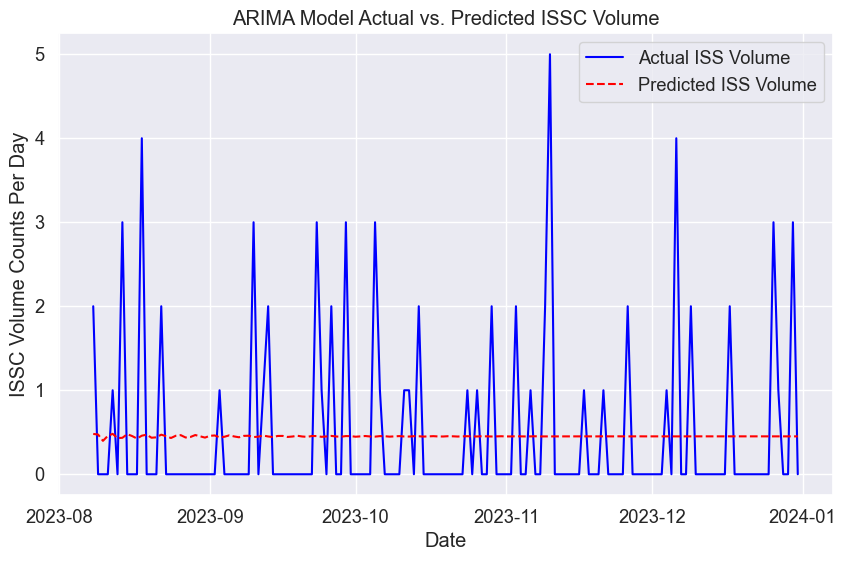

In [27]:
#Call function
eval_arima_model(train, test, p_values, d_values, q_values)

## Long Short Term Memory (LSTM)

### LSTM with Removing Outlier

In [28]:
#Removing outlier
outlier_df = new_df[new_df.index != '2023-07-11']

In [29]:
outlier_df

,volume,temp_volume,rhi_volume
2022-01-01,0.0,54.0,0.0
2022-01-02,1.0,52.0,20.0
2022-01-03,0.0,46.0,3.0
2022-01-04,0.0,68.0,3.0
2022-01-05,0.0,57.0,0.0
...,...,...,...
2023-12-27,1.0,71.0,1.0
2023-12-28,0.0,51.0,2.0
2023-12-29,0.0,61.0,6.0
2023-12-30,3.0,81.0,25.0


In [30]:
#Make a copy of the DataFrame
lstm_df = outlier_df.copy()

### Evaluate optimal number of lag variables

In [31]:
#Evaluate optimal number of lag features for ISSC volume, Temp Volume, and RHI Volume
issc_lag = [0, 1, 2]
temp_lag = [0, 1, 2]
rhi_lag = [0, 1, 2]

search_results2 = []

#Create a lag evaluation function which takes in number of lags I want to try on the issc, temp, and rhi features
def lag_evaluation(issc_lag, temp_lag, rhi_lag):
    #Make a copy of the dataframe
    lstm_df = outlier_df.copy()
    
    #Loop through variable and create the number of lag features that will be tested
    for i in range(1, issc_lag + 1):
        lstm_df[f'volume_lag{i}'] = lstm_df['volume'].shift(i)
        lstm_df[f'volume_lag{i}'].fillna(0, inplace = True)

    for i in range(1, temp_lag + 1):
        lstm_df[f'temp_volume_lag{i}'] = lstm_df['temp_volume'].shift(i)
        lstm_df[f'temp_volume_lag{i}'].fillna(0, inplace = True)

    for i in range(1, rhi_lag + 1):
        lstm_df[f'rhi_volume_lag{i}'] = lstm_df['rhi_volume'].shift(i)
        lstm_df[f'rhi_volume_lag{i}'].fillna(0, inplace = True)
    
    #Once all the features are created we assign X and Y variables    
    X3 = lstm_df.iloc[:, 1:]
    y3 = lstm_df['volume'].values

    #We do a train/test split on the X and Y variables
    X3_train, X3_test, y3_train, y3_test = train_test_split(X3, y3, test_size=0.2, random_state=42)

    #We create the LSTM model assigning the units, activation function, learning rate, loss
    model = Sequential([
        LSTM(units=50, activation='relu', input_shape=(X3_train.shape[1], 1)),
        Dense(1)
    ])
    model.compile(optimizer=Adam(learning_rate=0.01), loss='mse')
    
    # Train the model
    model.fit(X3_train, y3_train, epochs=100, batch_size = 32, verbose=0, validation_split=0.2)
    
    # Evaluate the model
    predictions = model.predict(X3_test)
    mse = mean_squared_error(y3_test, predictions)
    return mse

#We loop through each lag combination of issc, temp, and rhi
for vl in issc_lag:
    for tl in temp_lag:
        for rl in rhi_lag:
            mse = lag_evaluation(vl, tl, rl)
            search_results2.append((vl, tl, rl, mse))
            print(f"ISSC_Lag: {vl}, Temp_Lag: {tl}, RHI_Lag: {rl}, MSE: {mse}")

5/5 [==============================] - 0s 2ms/step
ISSC_Lag: 0, Temp_Lag: 0, RHI_Lag: 0, MSE: 0.6382615089457016
5/5 [==============================] - 0s 2ms/step
ISSC_Lag: 0, Temp_Lag: 0, RHI_Lag: 1, MSE: 0.5376651266367306
5/5 [==============================] - 0s 2ms/step
ISSC_Lag: 0, Temp_Lag: 0, RHI_Lag: 2, MSE: 0.8457408741404604
5/5 [==============================] - 0s 3ms/step
ISSC_Lag: 0, Temp_Lag: 1, RHI_Lag: 0, MSE: 0.7021292463693263
5/5 [==============================] - 0s 2ms/step
ISSC_Lag: 0, Temp_Lag: 1, RHI_Lag: 1, MSE: 0.6361242218901693
5/5 [==============================] - 0s 3ms/step
ISSC_Lag: 0, Temp_Lag: 1, RHI_Lag: 2, MSE: 0.558767526389043
5/5 [==============================] - 0s 2ms/step
ISSC_Lag: 0, Temp_Lag: 2, RHI_Lag: 0, MSE: 0.6001966976557559
5/5 [==============================] - 0s 3ms/step
ISSC_Lag: 0, Temp_Lag: 2, RHI_Lag: 1, MSE: 0.6306303730329368
5/5 [==============================] - 0s 3ms/step
ISSC_Lag: 0, Temp_Lag: 2, RHI_Lag: 2, MSE: 0.6

In [32]:
#Optimal number of lag variables
best_lag = min(search_results2, key=lambda x: x[3])
print(f"Optimal number of lag variables: ISSC Lag={best_lag[0]}, Temp Lag={best_lag[1]}, RHI Lag={best_lag[2]} with MSE={best_lag[3]}")

Optimal number of lag variables: ISSC Lag=0, Temp Lag=0, RHI Lag=1 with MSE=0.5376651266367306


In [33]:
#Save another copy of the dataframe
outlier_df2 = outlier_df.copy()

### Based of optimal number of lag variables, add to dataframe

Based off the results of the optimal lag features, we create those lag features that are optimal.

In [34]:
#Input the number of lag features

#Create loop to add lag features to dataframe
#for i in range(1, 2 + 1):
#    outlier_df2[f'volume_lag{i}'] = outlier_df2['volume'].shift(i)
    
# Fill missing values with 0
#outlier_df2['volume_lag1'] = outlier_df2['volume_lag1'].fillna(0)
#outlier_df2['volume_lag2'] = outlier_df2['volume_lag2'].fillna(0)

In [35]:
#for i in range(1, 0 + 1):
#    outlier_df2[f'temp_volume_lag{i}'] = outlier_df2['temp_volume'].shift(i)

#outlier_df2['temp_volume_lag1'] = outlier_df2['temp_volume_lag1'].fillna(0)
#outlier_df2['temp_volume_lag2'] = outlier_df2['temp_volume_lag2'].fillna(0)

In [36]:
for i in range(1, 1 + 1):
    outlier_df2[f'rhi_volume_lag{i}'] = outlier_df2['rhi_volume'].shift(i)

outlier_df2['rhi_volume_lag1'] = outlier_df2['rhi_volume_lag1'].fillna(0)
#outlier_df2['rhi_volume_lag2'] = outlier_df2['rhi_volume_lag2'].fillna(0)

In [37]:
outlier_df2

,volume,temp_volume,rhi_volume,rhi_volume_lag1
2022-01-01,0.0,54.0,0.0,0.0
2022-01-02,1.0,52.0,20.0,0.0
2022-01-03,0.0,46.0,3.0,20.0
2022-01-04,0.0,68.0,3.0,3.0
2022-01-05,0.0,57.0,0.0,3.0
...,...,...,...,...
2023-12-27,1.0,71.0,1.0,9.0
2023-12-28,0.0,51.0,2.0,1.0
2023-12-29,0.0,61.0,6.0,2.0
2023-12-30,3.0,81.0,25.0,6.0


### Hyperparameter tuning

In [39]:
#trying to find optimal hyper parameters for LSTM model

# Define the grid of hyperparameters to search
units = [50, 100, 150]
learning_rates = [0.01, 0.001, 0.0001]
batch_sizes = [16, 32, 64]
epoch = [50, 100, 150]

# Placeholder for storing the results
search_results = []

#Creating a function to evaluate and test the different hyperparamters to include units, learning rate, batch size, and epochs
def build_and_evaluate_model(units, learning_rate, batch_size, epoch):
    # Build the model
    X4 = outlier_df2.iloc[:, 1:]
    y4 = outlier_df2['volume'].values

    X4_train, X4_test, y4_train, y4_test = train_test_split(X4, y4, test_size=0.2, random_state=42)
    
    model = Sequential([
        LSTM(units=units, activation='relu', input_shape=(X4_train.shape[1], 1)),
        Dense(1)
    ])
    model.compile(optimizer=Adam(learning_rate=learning_rate), loss='mse')
    
    # Train the model
    model.fit(X4_train, y4_train, epochs=epoch, batch_size=batch_size, verbose=0, validation_split=0.2)
    
    # Evaluate the model
    predictions = model.predict(X4_test)
    mse = mean_squared_error(y4_test, predictions)
    return mse

# Iterate over each combination of hyperparameters
for u in units:
    for lr in learning_rates:
        for bs in batch_sizes:
            for ep in epoch:
                mse = build_and_evaluate_model(u, lr, bs, ep)
                search_results.append((u, lr, bs, ep, mse))
                print(f"Units: {u}, Learning Rate: {lr}, Batch Size: {bs}, Epochs: {ep}, MSE: {mse}")

5/5 [==============================] - 0s 2ms/step
Units: 50, Learning Rate: 0.01, Batch Size: 16, Epochs: 50, MSE: 0.6987521027993993
5/5 [==============================] - 0s 2ms/step
Units: 50, Learning Rate: 0.01, Batch Size: 16, Epochs: 100, MSE: 0.5502050336814612
5/5 [==============================] - 0s 2ms/step
Units: 50, Learning Rate: 0.01, Batch Size: 16, Epochs: 150, MSE: 0.5969769764894556
5/5 [==============================] - 0s 2ms/step
Units: 50, Learning Rate: 0.01, Batch Size: 32, Epochs: 50, MSE: 0.5931268329409203
5/5 [==============================] - 0s 2ms/step
Units: 50, Learning Rate: 0.01, Batch Size: 32, Epochs: 100, MSE: 0.5180156430964177
5/5 [==============================] - 0s 3ms/step
Units: 50, Learning Rate: 0.01, Batch Size: 32, Epochs: 150, MSE: 0.5984747038376396
5/5 [==============================] - 0s 3ms/step
Units: 50, Learning Rate: 0.01, Batch Size: 64, Epochs: 50, MSE: 0.6356134884532493
5/5 [==============================] - 0s 2ms/step


In [40]:
#List of search results
search_results

[(50, 0.01, 16, 50, 0.6987521027993993),
 (50, 0.01, 16, 100, 0.5502050336814612),
 (50, 0.01, 16, 150, 0.5969769764894556),
 (50, 0.01, 32, 50, 0.5931268329409203),
 (50, 0.01, 32, 100, 0.5180156430964177),
 (50, 0.01, 32, 150, 0.5984747038376396),
 (50, 0.01, 64, 50, 0.6356134884532493),
 (50, 0.01, 64, 100, 0.5588526489385779),
 (50, 0.01, 64, 150, 0.6411231567678687),
 (50, 0.001, 16, 50, 0.5441379396953606),
 (50, 0.001, 16, 100, 0.5817092875798746),
 (50, 0.001, 16, 150, 0.6841960449204303),
 (50, 0.001, 32, 50, 0.52859586296864),
 (50, 0.001, 32, 100, 0.5427548629281982),
 (50, 0.001, 32, 150, 0.5486188732925632),
 (50, 0.001, 64, 50, 0.5597284849848925),
 (50, 0.001, 64, 100, 0.5478141854304319),
 (50, 0.001, 64, 150, 0.5838611831643549),
 (50, 0.0001, 16, 50, 0.5548532082741829),
 (50, 0.0001, 16, 100, 0.5488535486629943),
 (50, 0.0001, 16, 150, 0.5432482271950277),
 (50, 0.0001, 32, 50, 0.5458052195753715),
 (50, 0.0001, 32, 100, 0.5487123700029185),
 (50, 0.0001, 32, 150, 0.

In [49]:
# Find the best hyperparameters
best_hyperparams = min(search_results, key=lambda x: x[4])
print(f"Best Hyperparameters: Units={best_hyperparams[0]}, Learning Rate={best_hyperparams[1]}, Batch Size={best_hyperparams[2]}, \
Epochs = {best_hyperparams[3]} with MSE={best_hyperparams[4]}")

Best Hyperparameters: Units=100, Learning Rate=0.01, Batch Size=32, Epochs = 100 with MSE=0.5097082982167754


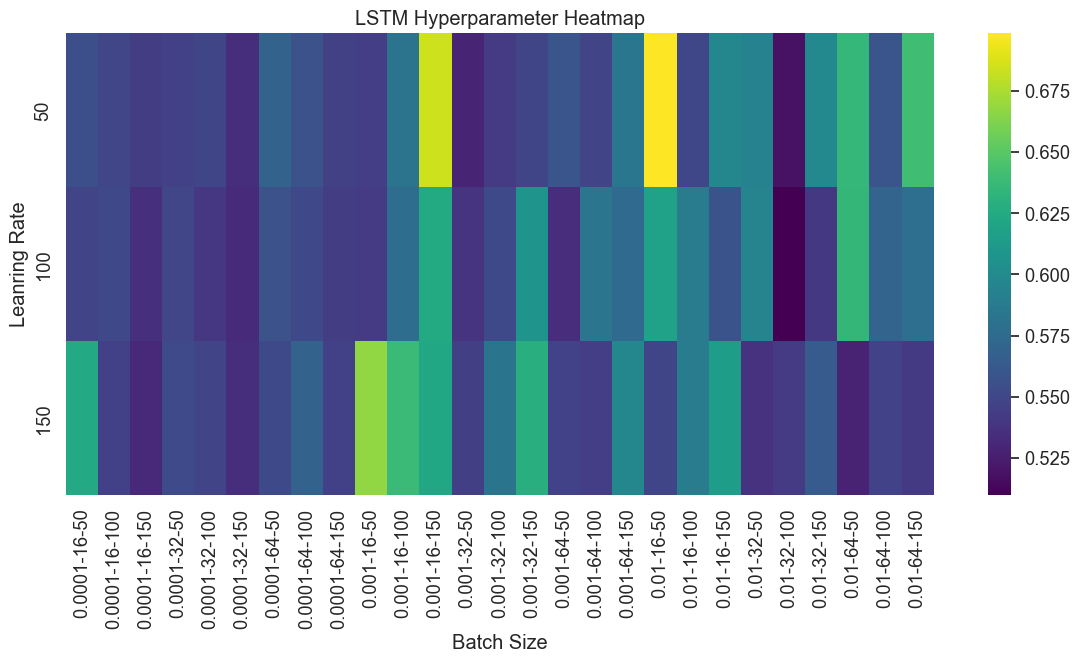

In [47]:
#Create a Heatmap to visualize hyperparameter tuning
heatmap_df = pd.DataFrame(search_results, columns = ['Units', 'Learning Rate', 'Batch Size', 'Epochs', 'MSE'])

pivot_df = heatmap_df.pivot_table(index='Units', columns= ['Learning Rate', 'Batch Size', 'Epochs'], values='MSE')

plt.figure(figsize = (14, 6))
sns.heatmap(pivot_df, cmap = 'viridis')

plt.title("LSTM Hyperparameter Heatmap")
plt.xlabel("Batch Size")
plt.ylabel('Leanring Rate')
plt.show()

### Most optimal number of lag variables and hyperparameters

In [50]:
# Model with optimal parameters from cell above
X5 = outlier_df2.iloc[:, 1:]
y5 = outlier_df2['volume'].values

X5_train, X5_test, y5_train, y5_test = train_test_split(X5, y5, test_size=0.2, random_state=42)

model = Sequential([
    LSTM(units = 100, activation = 'relu', input_shape = (X5_train.shape[1], 1)),
    Dense(1)
])

model.compile(optimizer = Adam(learning_rate = 0.01), loss = 'mse')

pred_values = []
actual_values = []

for epoch in range(100):
    model.fit(X5_train, y5_train, epochs = 1, batch_size = 32, validation_split = 0.2, verbose = 1)
    pred_values.append(model.predict(X5_test))
    actual_values.append(y_test)


test_loss = model.evaluate(X5_test, y5_test)
print(f'Test Loss: {test_loss}')

5/5 [==============================] - 0s 3ms/step - loss: 0.6048
Test Loss: 0.6047583818435669


23/23 [==============================] - 0s 2ms/step


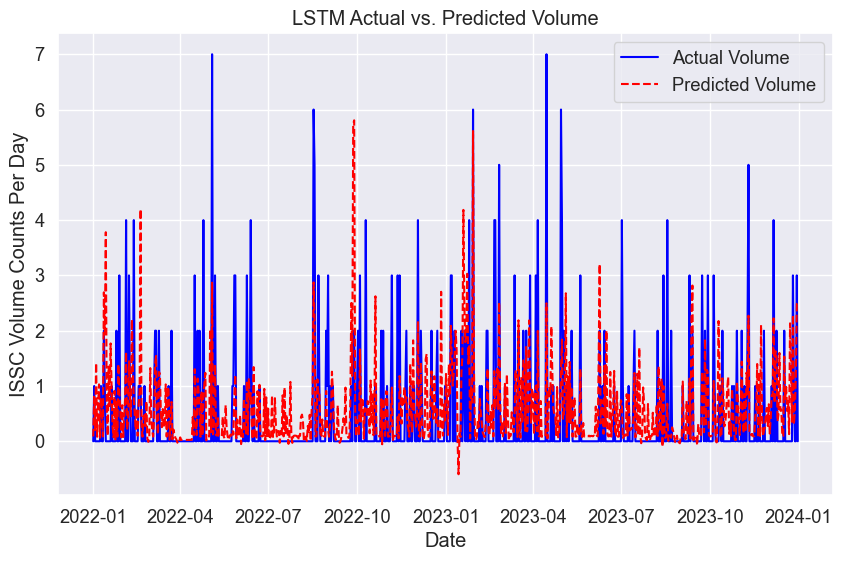

In [51]:
#Plotting actual vs. predicted issc volumes each day
actual_volume = outlier_df2['volume']
predicted_volume = model.predict(X5)

# Plot actual vs. predicted volumes
plt.figure(figsize=(10, 6))
plt.plot(actual_volume.index, actual_volume, label='Actual Volume', color='blue')
plt.plot(actual_volume.index, predicted_volume, label='Predicted Volume', color='red', linestyle='--')
plt.xlabel('Date')
plt.ylabel('ISSC Volume Counts Per Day')
plt.title('LSTM Actual vs. Predicted Volume')
plt.legend()
plt.grid(True)
plt.show()

In [52]:
#Save predictions results to DataFrame
results_df = pd.DataFrame(pred_values[-1])
actual_df = pd.DataFrame(y5_test)
X6_test = X5_test.copy()
X6_test.reset_index(inplace = True)
X6_test

,index,temp_volume,rhi_volume,rhi_volume_lag1
0,2023-04-14,55.0,0.0,0.0
1,2022-05-29,67.0,0.0,13.0
2,2022-10-30,49.0,0.0,7.0
3,2022-12-22,63.0,1.0,7.0
4,2023-05-31,45.0,0.0,0.0
...,...,...,...,...
141,2023-02-09,44.0,0.0,8.0
142,2023-01-26,49.0,23.0,36.0
143,2022-08-07,28.0,0.0,3.0
144,2022-05-16,61.0,0.0,1.0


## Analyzing Testing Results

Creating a new dataframe for visuals

In [53]:
actual_df.rename(columns={0 : 'actual_vals'}, inplace = True)

In [54]:
results_df.rename(columns = {0 : 'predictions'}, inplace = True)

In [55]:
combined_df = pd.concat([X6_test, actual_df, results_df], axis = 1)

In [56]:
combined_df['diff_pred'] = (combined_df['actual_vals'] - combined_df['predictions']).round(2).abs()

In [57]:
combined_df

,index,temp_volume,rhi_volume,rhi_volume_lag1,actual_vals,predictions,diff_pred
0,2023-04-14,55.0,0.0,0.0,0.0,0.086939,0.09
1,2022-05-29,67.0,0.0,13.0,0.0,0.053592,0.05
2,2022-10-30,49.0,0.0,7.0,0.0,0.095633,0.10
3,2022-12-22,63.0,1.0,7.0,1.0,0.333812,0.67
4,2023-05-31,45.0,0.0,0.0,0.0,0.097478,0.10
...,...,...,...,...,...,...,...
141,2023-02-09,44.0,0.0,8.0,0.0,0.113931,0.11
142,2023-01-26,49.0,23.0,36.0,0.0,0.051255,0.05
143,2022-08-07,28.0,0.0,3.0,0.0,-0.003075,0.00
144,2022-05-16,61.0,0.0,1.0,0.0,0.085776,0.09


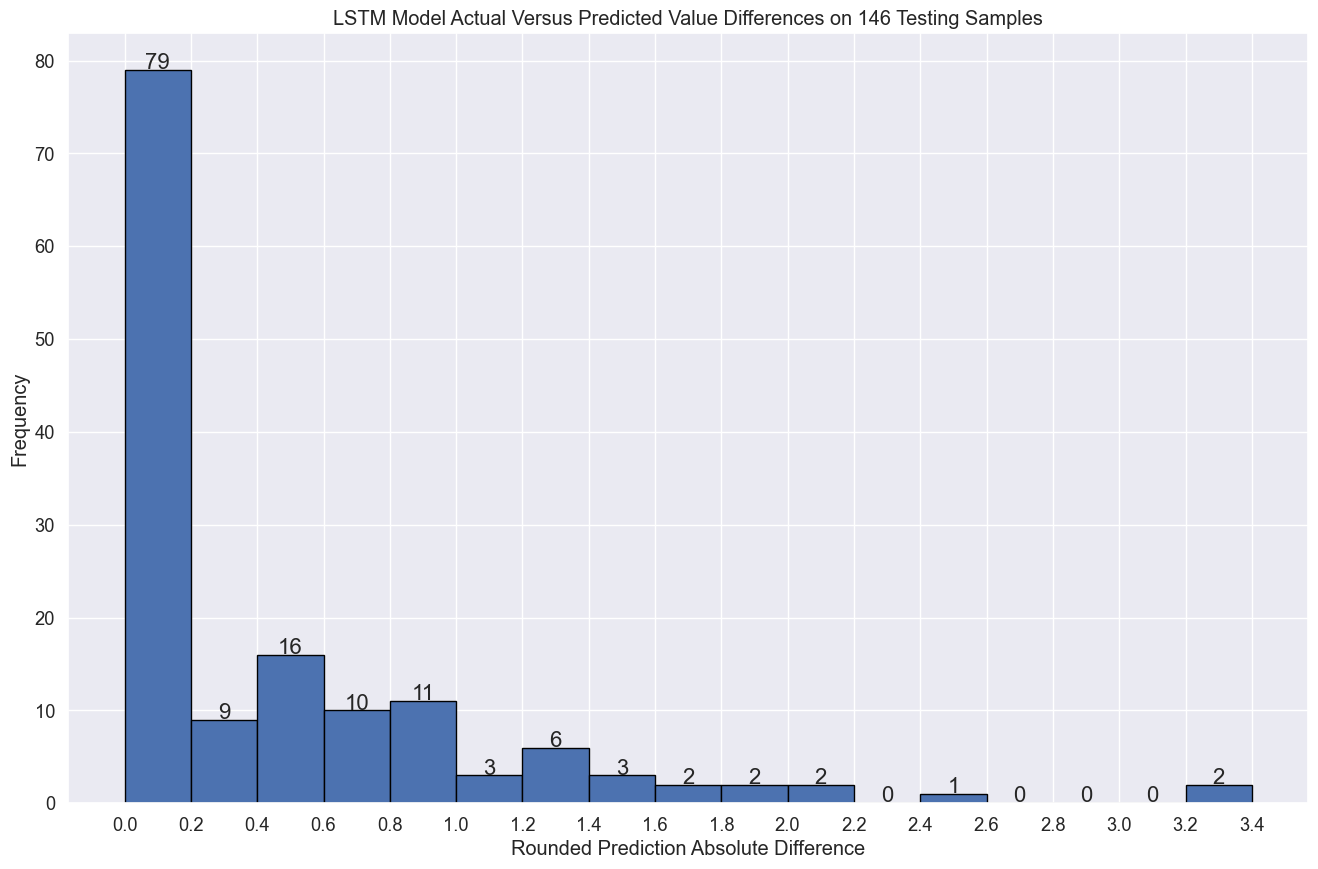

In [58]:
#Recreate the Time Series Plot from above into a histogram with binned differences between actual versus predicted results
min_val = combined_df['diff_pred'].min()
max_val = combined_df['diff_pred'].max()
bin_range = np.arange(min_val, max_val + 0.2, 0.2)

plt.figure(figsize = (16, 10))
#plt.hist(combined_df['diff_pred'], bins = bin_range)

hist_counts, hist_bins, _ = plt.hist(combined_df['diff_pred'], bins=bin_range, edgecolor='black')

# Add data labels above each bin
for i, bin_count in enumerate(hist_counts):
    plt.text(hist_bins[i] + 0.1, bin_count + 0.1, str(int(bin_count)), fontsize=16, ha='center')


plt.xlabel('Rounded Prediction Absolute Difference')
plt.ylabel('Frequency')
plt.title('LSTM Model Actual Versus Predicted Value Differences on 146 Testing Samples')
plt.xticks(np.arange(min_val, max_val + 0.2, 0.2))
plt.show()

In [59]:
#Checking on instances where the prediction was way off
combined_df[combined_df['diff_pred'] > 3]

,index,temp_volume,rhi_volume,rhi_volume_lag1,actual_vals,predictions,diff_pred
55,2023-08-18,44.0,10.0,0.0,4.0,0.679369,3.32
69,2022-02-19,80.0,22.0,22.0,1.0,4.197932,3.20


In [60]:
#Checking on instances where ISSC was 0 to see what the averages for each variable are
combined_df[combined_df['actual_vals'] < 1].mean()

index              2022-11-25 00:48:00
temp_volume                  46.908333
rhi_volume                       4.525
rhi_volume_lag1               6.116667
actual_vals                        0.0
predictions                   0.338752
diff_pred                         0.34
dtype: object

In [61]:
combined_df2 = combined_df[combined_df['actual_vals'] > 0]

In [62]:
combined_df2

,index,temp_volume,rhi_volume,rhi_volume_lag1,actual_vals,predictions,diff_pred
3,2022-12-22,63.0,1.0,7.0,1.0,0.333812,0.67
7,2022-03-23,57.0,3.0,4.0,2.0,0.711427,1.29
12,2022-03-20,46.0,18.0,7.0,1.0,0.919687,0.08
18,2023-08-12,65.0,5.0,0.0,1.0,1.135414,0.14
33,2022-03-07,59.0,15.0,3.0,2.0,1.542760,0.46
39,2023-09-29,56.0,8.0,2.0,3.0,1.232771,1.77
40,2022-12-23,49.0,18.0,1.0,2.0,0.605701,1.39
43,2023-10-12,25.0,5.0,14.0,1.0,0.074273,0.93
47,2023-03-13,56.0,28.0,4.0,3.0,0.474422,2.53
55,2023-08-18,44.0,10.0,0.0,4.0,0.679369,3.32


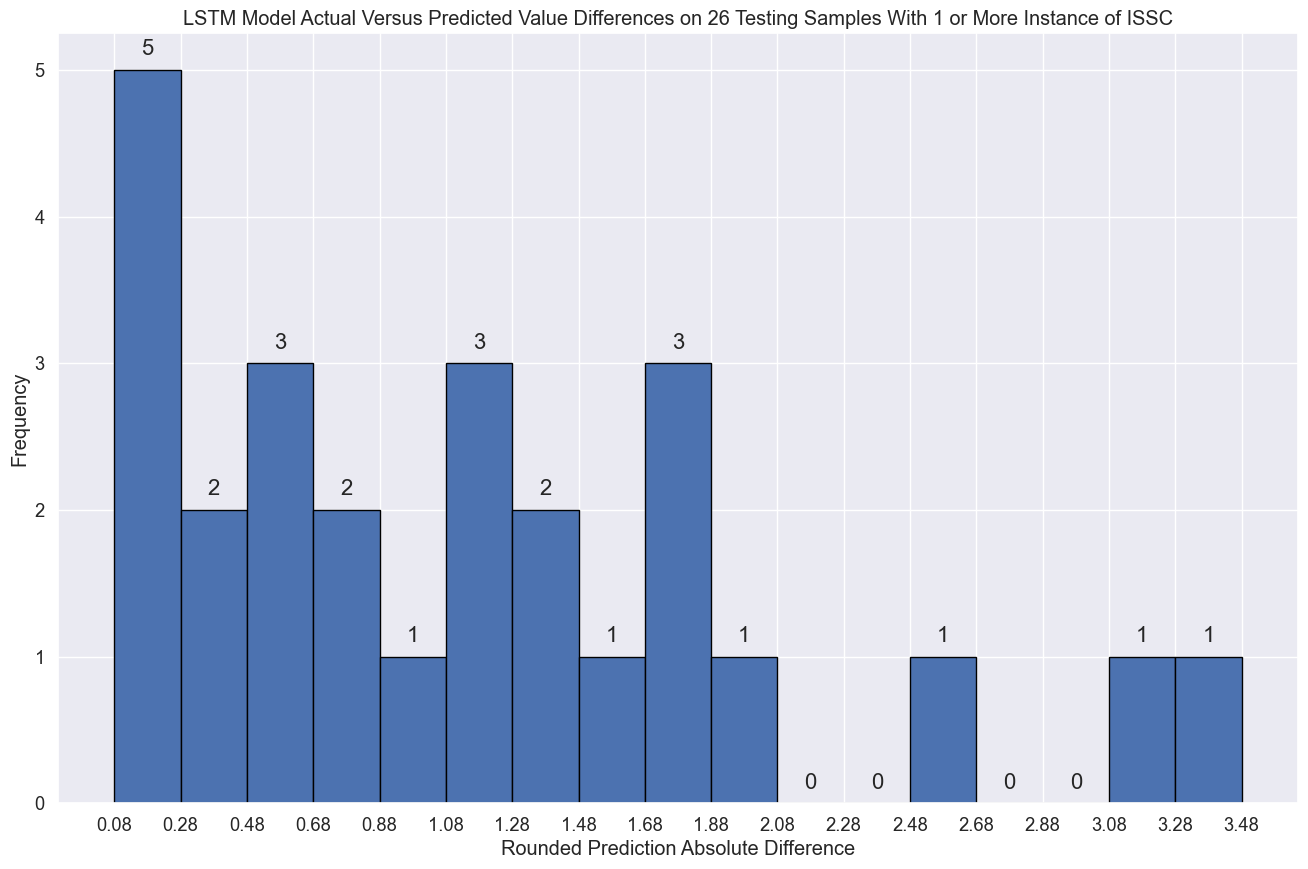

In [63]:
#Recreate the Time Series Plot from above into a histogram with binned differences between actual versus predicted results when ISSC is 1 or more
min_val2 = combined_df2['diff_pred'].min()
max_val2 = combined_df2['diff_pred'].max()
bin_range2 = np.arange(min_val2, max_val2 + 0.2, 0.2)

plt.figure(figsize = (16, 10))
#plt.hist(combined_df['diff_pred'], bins = bin_range)

hist_counts2, hist_bins2, _ = plt.hist(combined_df2['diff_pred'], bins=bin_range2, edgecolor='black')

# Add data labels above each bin
for i, bin_count in enumerate(hist_counts2):
    plt.text(hist_bins2[i] + 0.1, bin_count + 0.1, str(int(bin_count)), fontsize=16, ha='center')


plt.xlabel('Rounded Prediction Absolute Difference')
plt.ylabel('Frequency')
plt.title('LSTM Model Actual Versus Predicted Value Differences on 26 Testing Samples With 1 or More Instance of ISSC')
plt.xticks(np.arange(min_val2, max_val2 + 0.2, 0.2))
plt.show()

In [64]:
combined_df2.mean()

index              2023-01-28 08:18:27.692307712
temp_volume                            56.153846
rhi_volume                              9.884615
rhi_volume_lag1                         6.615385
actual_vals                             1.846154
predictions                             0.957236
diff_pred                               1.145385
dtype: object

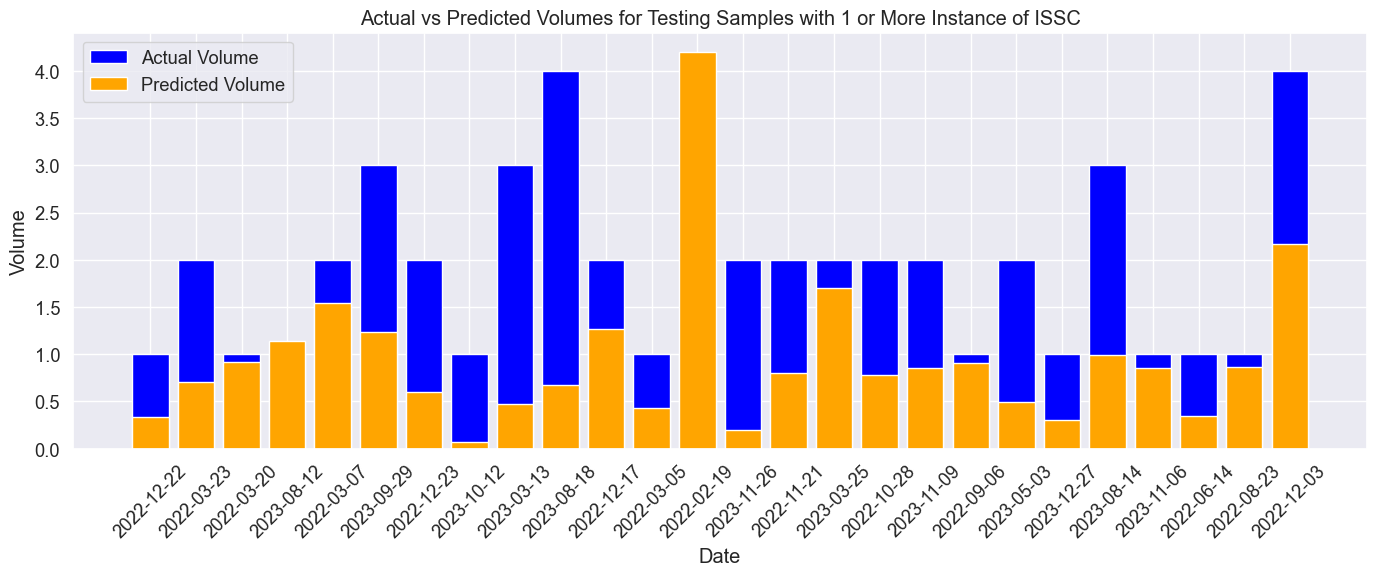

In [65]:
#Create a histogram that shows the individual days predictions
date_labels = combined_df2['index'].dt.strftime('%Y-%m-%d')

plt.figure(figsize=(14, 6))
plt.bar(date_labels, combined_df2['actual_vals'], color = 'blue', label = 'Actual Volume') 
plt.bar(date_labels, combined_df2['predictions'], color = 'orange', label = 'Predicted Volume')
plt.xlabel('Date')
plt.ylabel('Volume')
plt.title('Actual vs Predicted Volumes for Testing Samples with 1 or More Instance of ISSC')
plt.xticks(rotation = 45)
plt.legend()
plt.tight_layout()
plt.show()

## Predicting the volume of issc for the next 30 calandar days

In [66]:
#Import the ISSR dataset that includes 2024 data
data = pd.read_csv("C:/Users/Nicholas Weber/Downloads/Buffalo, NY_issr2021_2024.csv")

In [67]:
#Filter to only include 2024 data
df_2024 = data[(data['year'] == 2024) & (data['press'] != -9999)]
warnings.filterwarnings("ignore")
df_2024['issc'] = df_2024['issc'].replace({'yes': 1, 'no': 0})

In [68]:
#Remake the features needed for future predictions
df_2024['date'] = pd.to_datetime(df_2024['date'])
issc_counts_per_day2 = df_2024[df_2024['issc'] == 1].groupby(df_2024['date'].dt.date).size()
temp_count2 = df_2024[df_2024['temp_f'] < -42].groupby(df_2024['date'].dt.date).size()
rh_ice_count2 = df_2024[df_2024['rh_ice'] > 1].groupby(df_2024['date'].dt.date).size()

all_dates2 = pd.DataFrame(index=pd.date_range(start=df_2024['date'].min(), end=df_2024['date'].max(), freq='D'))
issc_counts_per_day2.name = 'issc'
temp_count2.name = 'temp_volume'
rh_ice_count2.name = 'rhi_volume'

df_2024_2 = all_dates2.join(issc_counts_per_day2, how='left').fillna(0)

df_2024_3 = pd.merge(df_2024_2, temp_count2, left_index = True, right_index = True, how = 'left').fillna(0)

new_df2 = pd.merge(df_2024_3, rh_ice_count2, left_index = True, right_index = True, how = 'left').fillna(0)

In [69]:
for i in range(1, 1 + 1):
    new_df2[f'rhi_volume_lag{i}'] = new_df2['rhi_volume'].shift(i)

new_df2['rhi_volume_lag1'] = new_df2['rhi_volume_lag1'].fillna(0)

In [70]:
new_df3 = new_df2[:30].copy()

In [71]:
#2024 dataframe
new_df3

,issc,temp_volume,rhi_volume,rhi_volume_lag1
2024-01-01,0.0,88,23.0,0.0
2024-01-02,0.0,75,9.0,23.0
2024-01-03,0.0,75,12.0,9.0
2024-01-04,2.0,57,11.0,12.0
2024-01-05,0.0,59,8.0,11.0
2024-01-06,0.0,64,9.0,8.0
2024-01-07,9.0,68,23.0,9.0
2024-01-08,0.0,74,13.0,23.0
2024-01-09,0.0,37,4.0,13.0
2024-01-10,0.0,16,0.0,4.0


In [72]:
#Predict future days
days_to_predict = 30

# Save predicted results 
predicted_volumes = []

# Make predictions for each day
for i in range(days_to_predict):
    # Get the latest volume lag data
    latest_volume_lag = new_df3.iloc[i,1:]

    # Reshape the input data
    X_pred = np.array([latest_volume_lag])
    X_pred = X_pred.reshape(X_pred.shape[0], X_pred.shape[1], 1)
    # Make predictions for the current day
    predicted_volume = model.predict(X_pred)
    
    # Append the predicted volume to the list
    predicted_volumes.append(predicted_volume[0][0])
    
    # Update X_pred for the next prediction
    latest_volume_lag = np.append(latest_volume_lag[1:], predicted_volume[0][0])
    X_pred = np.array([latest_volume_lag])
    X_pred = X_pred.reshape(X_pred.shape[0], X_pred.shape[1], 1)

# Get the latest date
latest_date = new_df.index[-1].date()

# Calculate the days we are predicting for
predicted_dates = [latest_date + pd.DateOffset(days=i) for i in range(1, days_to_predict + 1)]

# Print predicted volumes for each day
for date, volume in zip(predicted_dates, predicted_volumes):
    print(f"Predicted volume for {date}:", volume)

1/1 [==============================] - 0s 45ms/step
Predicted volume for 2024-01-01 00:00:00: 2.6095858
Predicted volume for 2024-01-02 00:00:00: 0.5077868
Predicted volume for 2024-01-03 00:00:00: 2.5470104
Predicted volume for 2024-01-04 00:00:00: 0.83414954
Predicted volume for 2024-01-05 00:00:00: 0.74787045
Predicted volume for 2024-01-06 00:00:00: 1.53552
Predicted volume for 2024-01-07 00:00:00: 0.9896836
Predicted volume for 2024-01-08 00:00:00: 1.9686635
Predicted volume for 2024-01-09 00:00:00: 0.017756835
Predicted volume for 2024-01-10 00:00:00: -0.062065955
Predicted volume for 2024-01-11 00:00:00: 1.6613574
Predicted volume for 2024-01-12 00:00:00: 1.0422407
Predicted volume for 2024-01-13 00:00:00: 1.1565007
Predicted volume for 2024-01-14 00:00:00: 0.23382398
Predicted volume for 2024-01-15 00:00:00: 0.7667506
Predicted volume for 2024-01-16 00:00:00: 1.7087485
Predicted volume for 2024-01-17 00:00:00: 0.47704822
Predicted volume for 2024-01-18 00:00:00: 1.2327712
Predi

In [73]:
predicted_dates_df = pd.DataFrame(predicted_dates, columns = ['Dates'])

In [74]:
predicted_volume_df = pd.DataFrame(predicted_volumes, columns = ['Pred_Volumes'])

In [75]:
combined_future = pd.merge(predicted_dates_df, predicted_volume_df, left_index = True, right_index = True, how = 'inner')

In [76]:
combined_future.set_index('Dates', inplace = True)
combined_future

,Pred_Volumes
Dates,
2024-01-01,2.609586
2024-01-02,0.507787
2024-01-03,2.547010
2024-01-04,0.834150
2024-01-05,0.747870
2024-01-06,1.535520
2024-01-07,0.989684
2024-01-08,1.968663
2024-01-09,0.017757


In [77]:
new_df4 = new_df3[:30].copy()

In [78]:
final_predictions = pd.merge(combined_future, new_df4, left_index = True, right_index = True, how = 'inner')

In [79]:
#Combine the predicitons data to the actual data
final_predictions['diff_pred'] = (final_predictions['issc'] - final_predictions['Pred_Volumes']).round(2).abs()
final_predictions.reset_index(inplace = True)
final_predictions

,Dates,Pred_Volumes,issc,temp_volume,rhi_volume,rhi_volume_lag1,diff_pred
0,2024-01-01,2.609586,0.0,88,23.0,0.0,2.61
1,2024-01-02,0.507787,0.0,75,9.0,23.0,0.51
2,2024-01-03,2.547010,0.0,75,12.0,9.0,2.55
3,2024-01-04,0.834150,2.0,57,11.0,12.0,1.17
4,2024-01-05,0.747870,0.0,59,8.0,11.0,0.75
5,2024-01-06,1.535520,0.0,64,9.0,8.0,1.54
6,2024-01-07,0.989684,9.0,68,23.0,9.0,8.01
7,2024-01-08,1.968663,0.0,74,13.0,23.0,1.97
8,2024-01-09,0.017757,0.0,37,4.0,13.0,0.02
9,2024-01-10,-0.062066,0.0,16,0.0,4.0,0.06


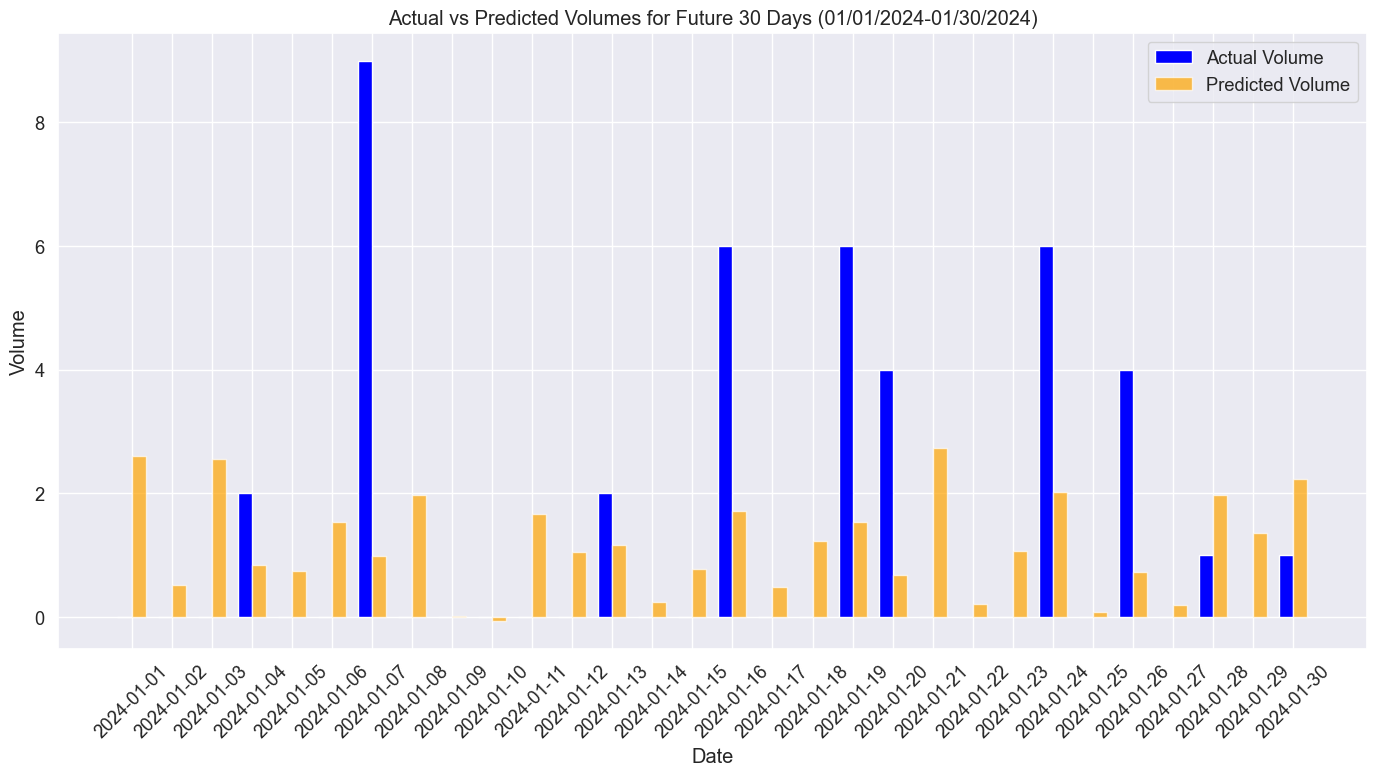

In [80]:
#Plot the future 30 days out comparing actual versus predicted volumes
date_labels2 = final_predictions['Dates'].dt.strftime('%Y-%m-%d')

plt.figure(figsize=(14, 8))
# Set the width of each bar
bar_width = 0.35

# Set the positions of the bars for the actual volumes
plt.bar(np.arange(len(date_labels2)), final_predictions['issc'], width=bar_width, color='blue', label='Actual Volume')

# Set the positions of the bars for the predicted volumes
plt.bar(np.arange(len(date_labels2)) + bar_width, final_predictions['Pred_Volumes'], width=bar_width, color='orange', label='Predicted Volume', alpha=0.7)

plt.xlabel('Date')
plt.ylabel('Volume')
plt.title('Actual vs Predicted Volumes for Future 30 Days (01/01/2024-01/30/2024)')
plt.xticks(np.arange(len(date_labels2)) + bar_width / 2, date_labels2, rotation=45)
plt.legend()
plt.tight_layout()
plt.show()

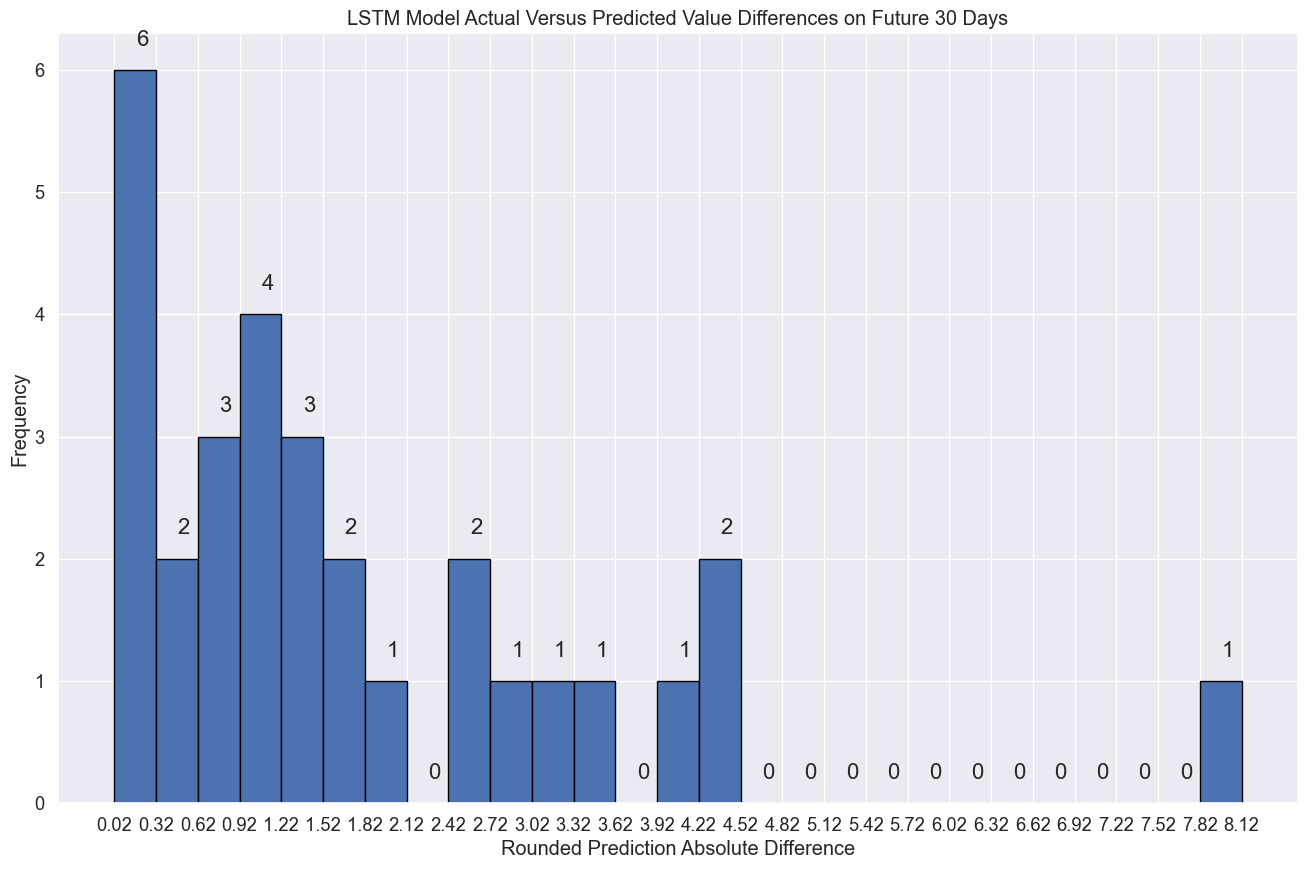

In [90]:
#Create a histogrram that bins the predicted differences
min_val = final_predictions['diff_pred'].min()
max_val = final_predictions['diff_pred'].max()
bin_range = np.arange(min_val, max_val + 0.3, 0.3)

plt.figure(figsize = (16, 10))
#plt.hist(combined_df['diff_pred'], bins = bin_range)

hist_counts, hist_bins, _ = plt.hist(final_predictions['diff_pred'], bins=bin_range, edgecolor='black')

# Add data labels above each bin
for i, bin_count in enumerate(hist_counts):
    plt.text(hist_bins[i] + 0.2, bin_count + 0.2, str(int(bin_count)), fontsize=16, ha='center')


plt.xlabel('Rounded Prediction Absolute Difference')
plt.ylabel('Frequency')
plt.title('LSTM Model Actual Versus Predicted Value Differences on Future 30 Days')
plt.xticks(np.arange(min_val, max_val + 0.3, 0.3))
plt.show()